In [ ]:
%%bash

pip install pandas \
    seaborn \
    sklearn \
    catboost \
    scikit-optimize tqdm \
    TPOT \
    imbalanced-learn


In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import json
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from tpot import TPOTClassifier

# Linear Methods
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

# Ensemble methods
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

# Multi layer perceptron
from sklearn.neural_network import MLPClassifier

# Suport Vector Machine
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report , confusion_matrix

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import tqdm

In [91]:
# Remove Warnig messages
warnings.simplefilter('ignore')

Read Data

In [19]:
df = pd.read_csv('diabetes.csv')

print(f'Shape: {df.shape}\n')

df.head()

Shape: (768, 9)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Features and labels

In [23]:
features = df.drop('Outcome', axis = 1)
labels = df['Outcome']

In [24]:
features = StandardScaler().fit_transform(features)

Train and test split

In [26]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .2)

Models

In [27]:
models = {
    'Logistic Regression': LogisticRegression,
    'Catboost': CatBoostClassifier,
#     'Ridge': RidgeClassifier,
#     'AdaBoost': AdaBoostClassifier,
#     'Bagging': BaggingClassifier,
    'Gradient Boosting': GradientBoostingClassifier,
    'Random Forest': RandomForestClassifier,
    'KNeighborsClassifier': KNeighborsClassifier,
    'LinearSVC': LinearSVC,
    'SGDClassifier': SGDClassifier
}

param_search = {
    'Logistic Regression': {
        'penalty': ["l1", "l2"],
        'C': Real(1e-4, 25.),
        'solver': ['liblinear']
    },
    'Catboost': {
        'iterations': [100],
        'depth':Integer(2,10),
        'learning_rate': Real(.001, 1.0),
        'silent': [True],
        'l2_leaf_reg': Real(.01, 1.0)
        },
#     'Ridge': {
        
#     },
#     'AdaBoost': {
        
#     },
#     'Bagging': {
        
#     },
    'Gradient Boosting': {
        'learning_rate': Real(1e-3, 1.),
        'max_depth': Integer(1, 11),
        'min_samples_split': Integer(2, 21),
        'min_samples_leaf': Integer(1, 21),
        'subsample': Real(0.05, 1.),
        'max_features': Real(0.05, 1.)
    },
    'Random Forest': {
        'criterion': Categorical(["gini", "entropy"]),
        'max_features': Real(.05, 1.),
        'min_samples_split': Integer(2,21),
        'min_samples_leaf':  Integer(1,21),
        'bootstrap': [True, False]
    },
    'KNeighborsClassifier':{
        'n_neighbors': Integer(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },
    'LinearSVC':{
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': Real(1e-5, 1e-1),
        'C': Real(1e-4, 25.)
    },
    'SGDClassifier':{
        'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['elasticnet'],
        'alpha': Real(0.0, 0.001),
        'learning_rate': ['invscaling', 'constant'],
        'fit_intercept': [True, False],
        'l1_ratio': Real(0.25, 0.5),
        'eta0': Real(0.01, 0.1),
        'power_t': Real(0.5, 50.0)
    }
}

params = {i:{} for i in models}

fit_params = {
    'Logistic Regression': {},
    'Catboost': {'silent':True},
    'Ridge': {},
    'AdaBoost': {},
    'Bagging': {},
    'Gradient Boosting': {},
    'Random Forest': {},
    'KNeighborsClassifier': {},
    'LinearSVC': {},
    'SGDClassifier': {}
}

### Cross validation

Test with default parameters

In [28]:
%%time

# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tSTD: {np.std(score):.3f}\tScores: {score}\n')
    
warnings.simplefilter('default')

>> Model: Logistic Regression
Mean Score: 0.727	STD: 0.022	Scores: [0.7312963  0.70347222 0.71522879 0.76788124 0.71801347]

>> Model: Catboost
Mean Score: 0.737	STD: 0.038	Scores: [0.70703704 0.7046875  0.74823657 0.8060054  0.72138047]

>> Model: Gradient Boosting
Mean Score: 0.736	STD: 0.022	Scores: [0.75833333 0.70694444 0.74823657 0.75438596 0.71127946]

>> Model: Random Forest
Mean Score: 0.721	STD: 0.033	Scores: [0.69703704 0.68350694 0.74823657 0.77159244 0.70286195]

>> Model: KNeighborsClassifier
Mean Score: 0.692	STD: 0.018	Scores: [0.68277778 0.6734375  0.71730874 0.71120108 0.67760943]

>> Model: LinearSVC
Mean Score: 0.730	STD: 0.022	Scores: [0.7412963  0.70347222 0.72038343 0.76788124 0.71801347]

>> Model: SGDClassifier
Mean Score: 0.700	STD: 0.032	Scores: [0.66777778 0.66006944 0.72092603 0.74527665 0.70707071]

CPU times: user 16.3 s, sys: 1.26 s, total: 17.6 s
Wall time: 11 s


### Parameter Tunning

In [ ]:
%%time

# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

for i in tqdm.tqdm(models):

    searcher = BayesSearchCV(
        estimator = models[i](), 
        search_spaces = param_search[i], 
        error_score = 0, n_iter = 50, cv = cv
    )

    searcher.fit(features, labels)

    params[i] = searcher.best_params_
    
warnings.simplefilter('default')

 14%|█▍        | 1/7 [01:14<07:24, 74.09s/it]

Store parameters on file

In [ ]:
with open('params.json', 'w') as f:
    json.dump(params, f, indent = 4)

Load parameters

In [ ]:
with open('params.json', 'r') as f:
    params = json.load(f)

Test again with parameters

In [ ]:
%%time

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](** params[i]), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tScores: {score}\n')

Make Predictions

In [94]:
predictions = {}

for i in models:
    predictions[i] = cross_val_predict(models[i](** fit_params[i]), features, labels, method = 'predict')

predictions_df = pd.DataFrame(predictions)

>>>> Model: Logistic Regression


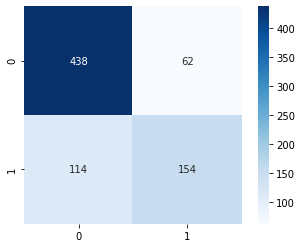

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.71      0.57      0.64       268

    accuracy                           0.77       768
   macro avg       0.75      0.73      0.73       768
weighted avg       0.77      0.77      0.76       768

>>>> Model: Catboost


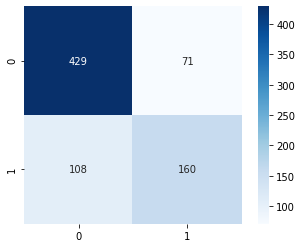

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       500
           1       0.69      0.60      0.64       268

    accuracy                           0.77       768
   macro avg       0.75      0.73      0.73       768
weighted avg       0.76      0.77      0.76       768

>>>> Model: Gradient Boosting


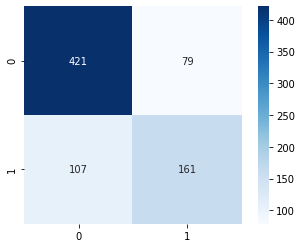

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       500
           1       0.67      0.60      0.63       268

    accuracy                           0.76       768
   macro avg       0.73      0.72      0.73       768
weighted avg       0.75      0.76      0.75       768

>>>> Model: Random Forest


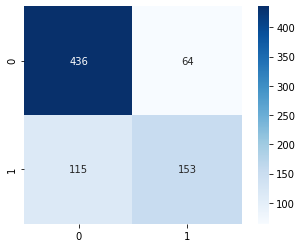

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       500
           1       0.71      0.57      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768

>>>> Model: KNeighborsClassifier


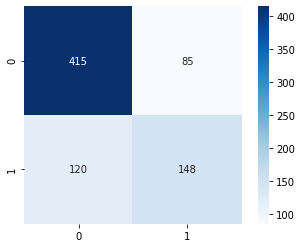

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       500
           1       0.64      0.55      0.59       268

    accuracy                           0.73       768
   macro avg       0.71      0.69      0.70       768
weighted avg       0.73      0.73      0.73       768

>>>> Model: LinearSVC


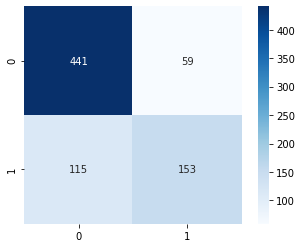

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       500
           1       0.72      0.57      0.64       268

    accuracy                           0.77       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.77      0.77       768

>>>> Model: SGDClassifier


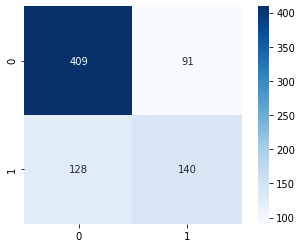

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       500
           1       0.61      0.52      0.56       268

    accuracy                           0.71       768
   macro avg       0.68      0.67      0.67       768
weighted avg       0.71      0.71      0.71       768



In [107]:
for i in predictions_df.columns:
    print(f'>>>> Model: {i}')
    
    sns.heatmap(
        confusion_matrix(labels, predictions_df[i]),
        cmap="Blues", square=True, annot = True, fmt = '.0f'
    )

    plt.show()

    print(classification_report(labels, predictions_df[i]))

In [93]:
predictions_prob = {}

for i in models:
    try:
        predictions_prob[i] = cross_val_predict(models[i](** fit_params[i]), features, labels, method = 'predict_proba')
    except:
        pass

predictions_prov_df = pd.DataFrame({i: predictions_prob[i][:,1] for i in predictions_prob})

In [92]:
cols = predictions_prov_df.columns

roc_scores = pd.DataFrame([
    roc_auc_score(labels, predictions_df[i])
    for i in cols
    
], index = cols)

roc_scores

,0
Logistic Regression,0.725313
Catboost,0.727507
Gradient Boosting,0.721373
Random Forest,0.725910
KNeighborsClassifier,0.691119


### Ensemble with mean of probabilities

AUC Score for mean of models

In [96]:
roc_auc_score(labels, predictions_df.mean(axis = 1))

0.78225

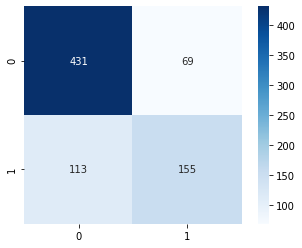

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       500
           1       0.69      0.58      0.63       268

    accuracy                           0.76       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.76      0.76      0.76       768



In [114]:
pred_mean = predictions_df.mean(axis = 1).apply(lambda f: 1 if f >= .5 else 0)

sns.heatmap(
    confusion_matrix(labels, pred_mean),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred_mean))

### Ensemble with vote

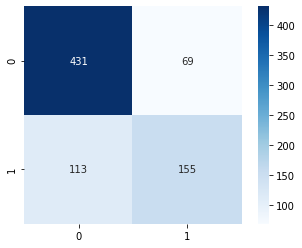

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       500
           1       0.69      0.58      0.63       268

    accuracy                           0.76       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.76      0.76      0.76       768



In [108]:
pred_vote = predictions_df.mean(axis = 1).apply(lambda f: 1 if f >= .5 else 0)

sns.heatmap(
    confusion_matrix(labels, pred_vote),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred_vote))

### TPOT auto ml

Find best model

In [ ]:
# Create a tpot optimizer with parameters
tpot = TPOTClassifier(scoring = 'balanced_accuracy', 
                     max_time_mins = 480, 
                     n_jobs = -1,
                     verbosity = 2,
                     cv = 5,
                     early_stop = 5
                     )

tp_fit = tpot.fit(features, labels)

tpot.export('diabetes_pipeline.py')

Resulting pipeline:

In [109]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectFwe, VarianceThreshold, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

# Average CV score on the training set was: 0.7709182389937107
tpot_pipeline = make_pipeline(
    PCA(iterated_power=6, svd_solver="randomized"),
    SelectFwe(score_func=f_classif, alpha=0.034),
    VarianceThreshold(threshold=0.0005),
    MaxAbsScaler(),
    FastICA(tol=0.8),
    SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=1.0, learning_rate="invscaling", loss="hinge", penalty="elasticnet", power_t=0.5)
)

In [110]:
score = cross_val_score(tpot_pipeline, features, labels, cv = cv, 
                         scoring = 'balanced_accuracy', fit_params = fit_params[i]
                        )
scores[i] = {'mean': np.mean(score), 'all': score}

print(f'Mean Score: {np.mean(score):.3f}\tScores: {score}\n')

Mean Score: 0.759	Scores: [0.73388889 0.7140625  0.70808464 0.81747638 0.81902357]



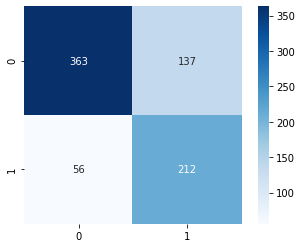

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       500
           1       0.61      0.79      0.69       268

    accuracy                           0.75       768
   macro avg       0.74      0.76      0.74       768
weighted avg       0.78      0.75      0.75       768



In [111]:
pred = cross_val_predict(tpot_pipeline, features, labels)

sns.heatmap(
    confusion_matrix(labels, pred),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred))